In [1]:
import os

os.environ["BRASA_DATA_PATH"] = "D:\\brasa"

In [2]:
import numpy as np

In [3]:
import sys
sys.path.append('..')

from datetime import datetime

import pandas as pd
import pyarrow.dataset as ds
import pyarrow.compute as pc
import pyarrow

import brasa

man = brasa.engine.CacheManager()

In [4]:
ds_cotahist = brasa.get_dataset("b3-cotahist")

In [5]:
tb_cotahist = ds_cotahist\
        .filter(pc.field("instrument_market") == 10)\
        .filter(pc.field("bdi_code") == 14)\
        .filter(pc.is_in(pc.utf8_slice_codeunits(pc.field("isin"), 6, 9), pyarrow.array(["CTF"])))\
        .filter(pc.starts_with(pc.field("specification_code"), "CI"))\
        .scanner(columns=["refdate", "symbol", "open", "high", "low", "close", "volume", "trade_quantity", "traded_contracts", "distribution_id"])\
        .to_table()

In [7]:
etfs = ["BBOV11",
        "BOVB11",
        "IBOB11",
        "XBOV11",
        "BOVA11",
        "BOVV11",
        "BOVS11",
        "BOVX11"]

In [38]:
from bizdays import Calendar, set_option

set_option("mode", "pandas")
cal = Calendar.load("B3")

In [39]:
etf_prices = tb_cotahist.filter(pc.field("symbol").isin(etfs)).sort_by("refdate").to_pandas()\
    .pivot_table(values="close", index="refdate", columns="symbol")

In [40]:
idx = cal.seq(etf_prices.index[0], etf_prices.index[-1])

In [41]:
etf_prices = etf_prices.reindex(index=idx)

In [46]:
year = 2019
etf_prices.loc[(etf_prices.index >= datetime(year, 1, 1))  & (etf_prices.index <= datetime(year, 12, 31)), :]

symbol,BBOV11,BOVA11,BOVB11,BOVS11,BOVV11,BOVX11,IBOB11,XBOV11
2019-01-02,NaN,87.90,NaN,NaN,91.45,NaN,NaN,89.61
2019-01-03,NaN,88.00,NaN,NaN,91.92,NaN,NaN,90.15
2019-01-04,NaN,88.50,NaN,NaN,92.28,NaN,NaN,90.74
2019-01-07,NaN,88.48,NaN,NaN,92.14,NaN,NaN,90.30
2019-01-08,NaN,88.83,NaN,NaN,92.42,NaN,NaN,90.66
...,...,...,...,...,...,...,...,...
2019-12-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
etfs = pd.read_csv("etfs-listados-20231014.csv", encoding="latin1", sep=";")

In [8]:
etfs["symbol"] = etfs["Código"] + "11"
etfs = etfs.set_index("symbol")

In [9]:
selected_etfs = tb_cotahist\
    .filter(pc.field("symbol").isin(etfs.index))\
    .group_by("symbol")\
    .aggregate([([], "count_all")])\
    .sort_by([("count_all", "descending")])\
    .filter(pc.field("count_all") >= 252)\
    .to_pandas()

In [10]:
prices = tb_cotahist.filter(pc.field("symbol").isin(selected_etfs["symbol"]))\
    .filter(pc.field("refdate") >= datetime(2022, 9, 1))\
    .select(["refdate", "symbol", "close"])\
    .to_pandas()\
    .pivot_table(values="close", index="refdate", columns="symbol")\
    .dropna(axis=1)
prices.shape

(322, 50)

In [12]:
rets = np.log(prices).diff().dropna(axis=0)

In [13]:
geo = etfs.loc[rets.columns, "Geografia"]

In [14]:
import matplotlib.colors as mcolors

cmap = dict(zip(geo.unique(), list(mcolors.TABLEAU_COLORS.values())))
geoc = geo.map(cmap)

In [15]:
geo

symbol
5GTK11        US
ACWI11        US
ALUG11        US
BBOV11        BR
BBSD11        BR
BITH11    CRIPTO
BOVA11        BR
BOVB11        BR
BOVV11        BR
BOVX11        BR
BRAX11        BR
CMDB11        BR
CRPT11    CRIPTO
DEFI11    CRIPTO
DIVO11        BR
ESGD11        US
ESGE11        EM
ESGU11        US
ETHE11    CRIPTO
EURP11        EU
GOLD11        AU
GOVE11        BR
HASH11    CRIPTO
ISUS11        BR
IVVB11        US
JOGO11        US
MATB11        BR
META11    CRIPTO
NASD11        US
NFTS11    CRIPTO
PIBB11        BR
QBTC11    CRIPTO
QDFI11    CRIPTO
QETH11    CRIPTO
SMAC11        BR
SMAL11        BR
SPXB11        US
SPXI11        US
TECB11        BR
TECK11        US
TRIG11        BR
URET11        US
USAL11        US
USTK11        US
UTEC11        US
WEB311    CRIPTO
WRLD11        US
XBOV11        BR
XFIX11        BR
XINA11        CN
Name: Geografia, dtype: object

In [16]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

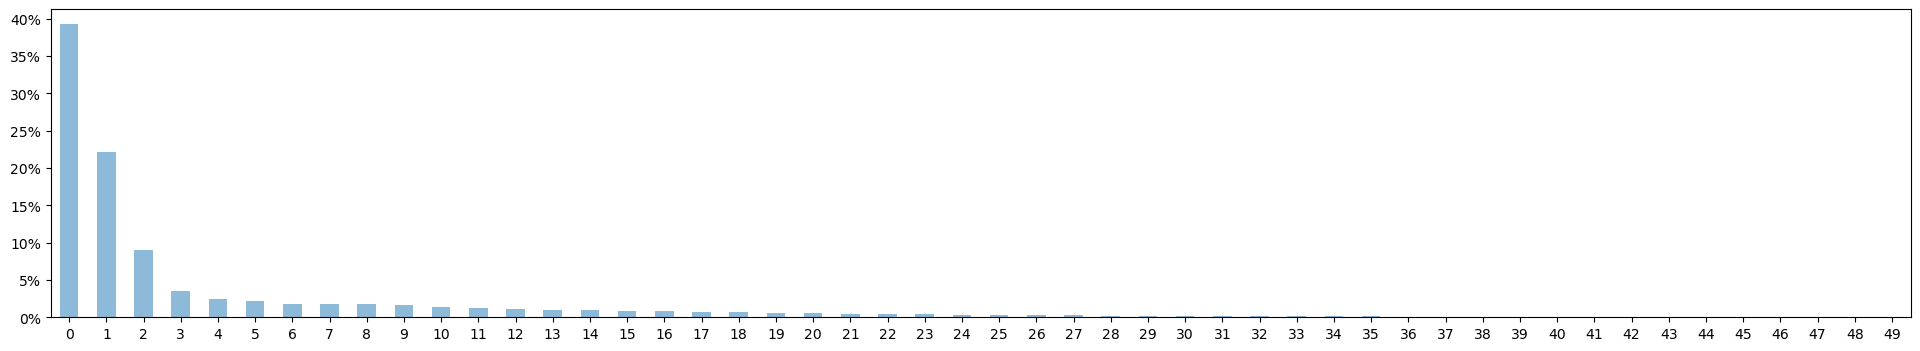

In [17]:
pca = sm.PCA(rets, standardize=True, demean=True)

fig, ax = plt.subplots(figsize=(24, 4))
(100 * pca.eigenvals / pca.eigenvals.sum()).head(50).plot.bar(rot=0, ax=ax, alpha=0.5).yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
# for i in [1, 5, 10, 90]:
#     ax.axhline(y=i, color='black', linestyle='--', alpha=0.5, linewidth=1)
plt.show()

<Axes: xlabel='symbol'>

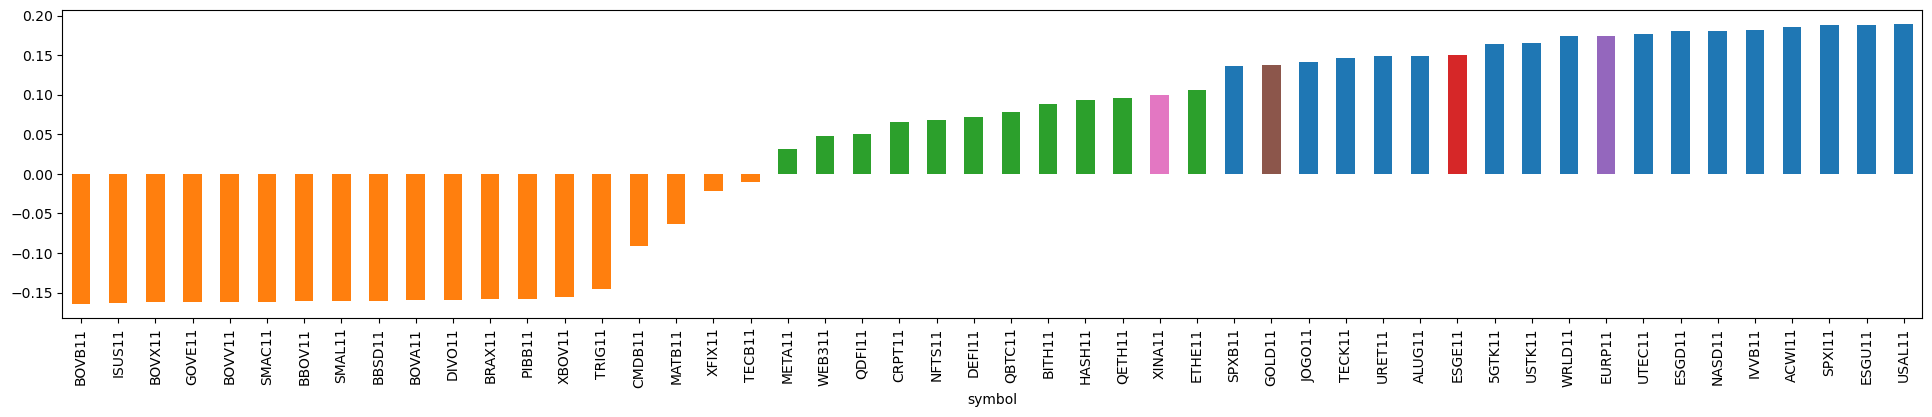

In [18]:
x = pca.loadings.loc[:, "comp_00"].sort_values()
x.plot.bar(figsize=(24, 4), color=geoc.loc[x.index])

<Axes: xlabel='symbol'>

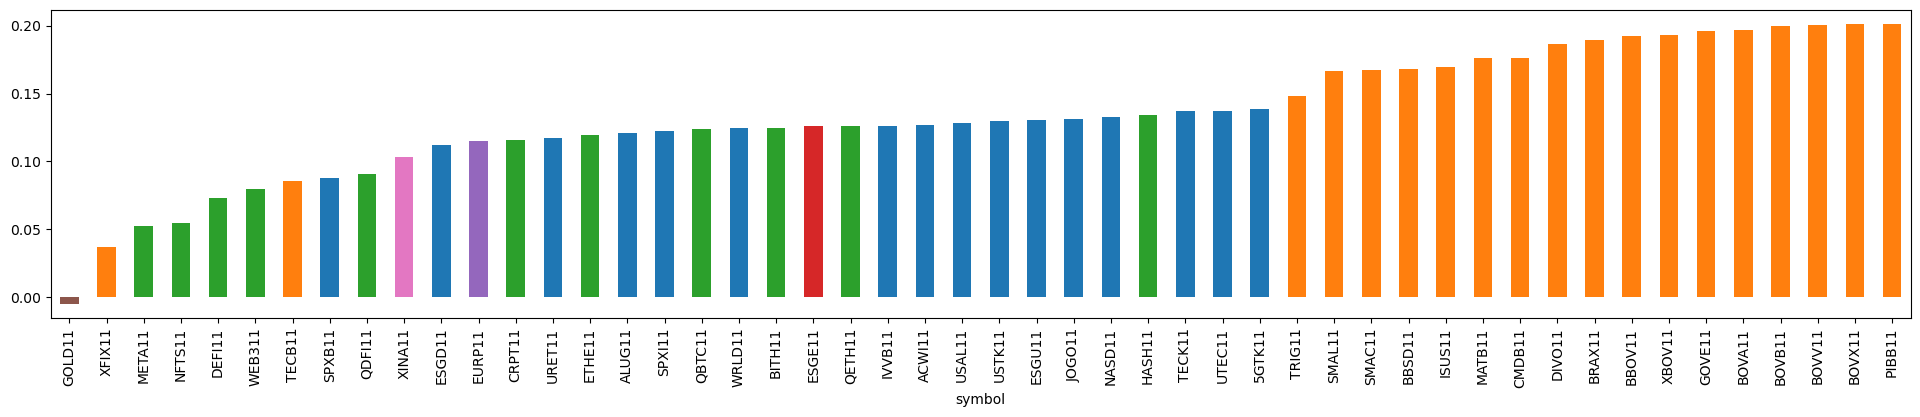

In [19]:
x = pca.loadings.loc[:, "comp_01"].sort_values()
x.plot.bar(figsize=(24, 4), color=geoc.loc[x.index])

<Axes: xlabel='symbol'>

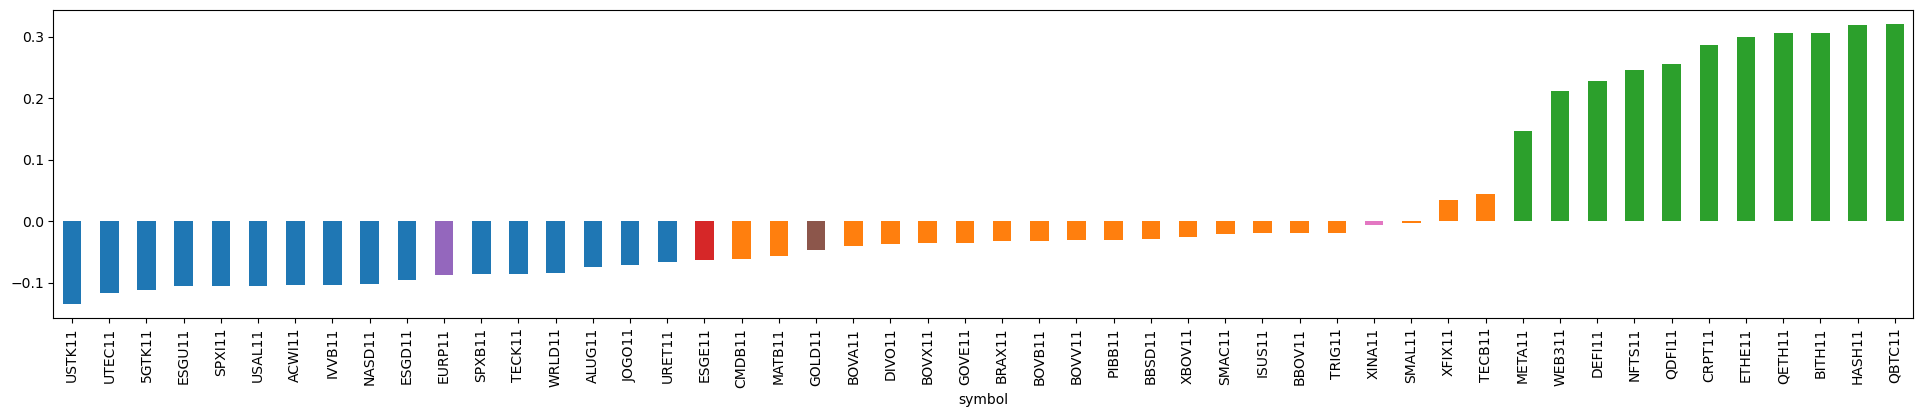

In [20]:
x = pca.loadings.loc[:, "comp_02"].sort_values()
x.plot.bar(figsize=(24, 4), color=geoc.loc[x.index])

<Axes: xlabel='symbol'>

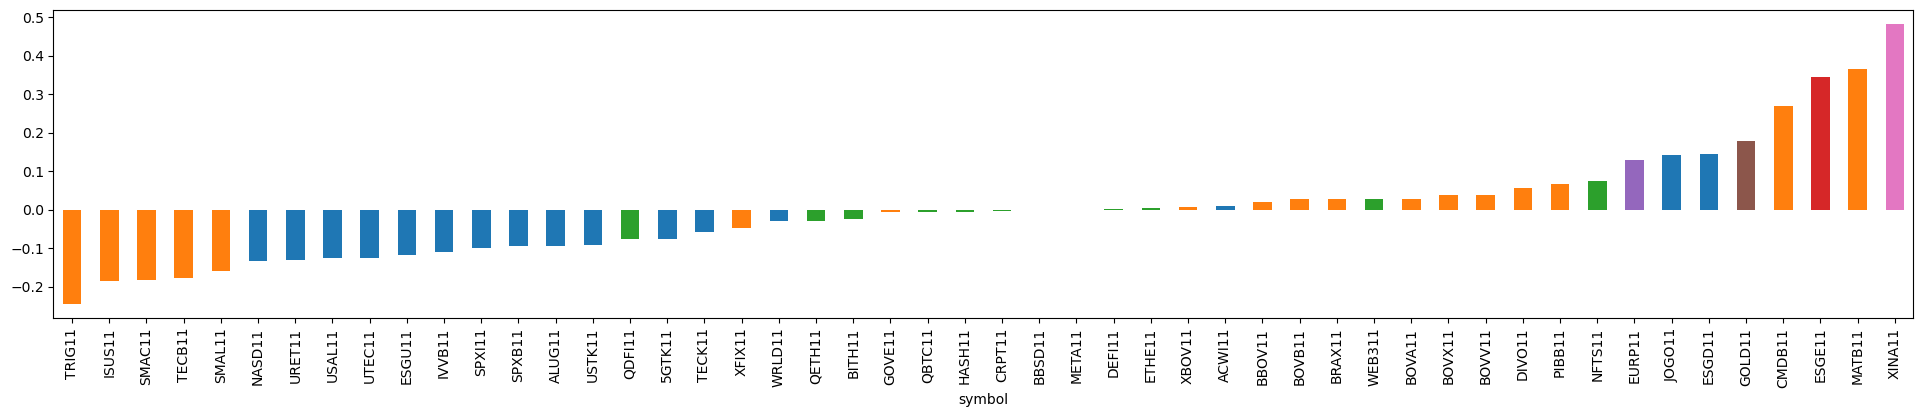

In [21]:
x = pca.loadings.loc[:, "comp_03"].sort_values()
x.plot.bar(figsize=(24, 4), color=geoc.loc[x.index])

<Axes: xlabel='symbol'>

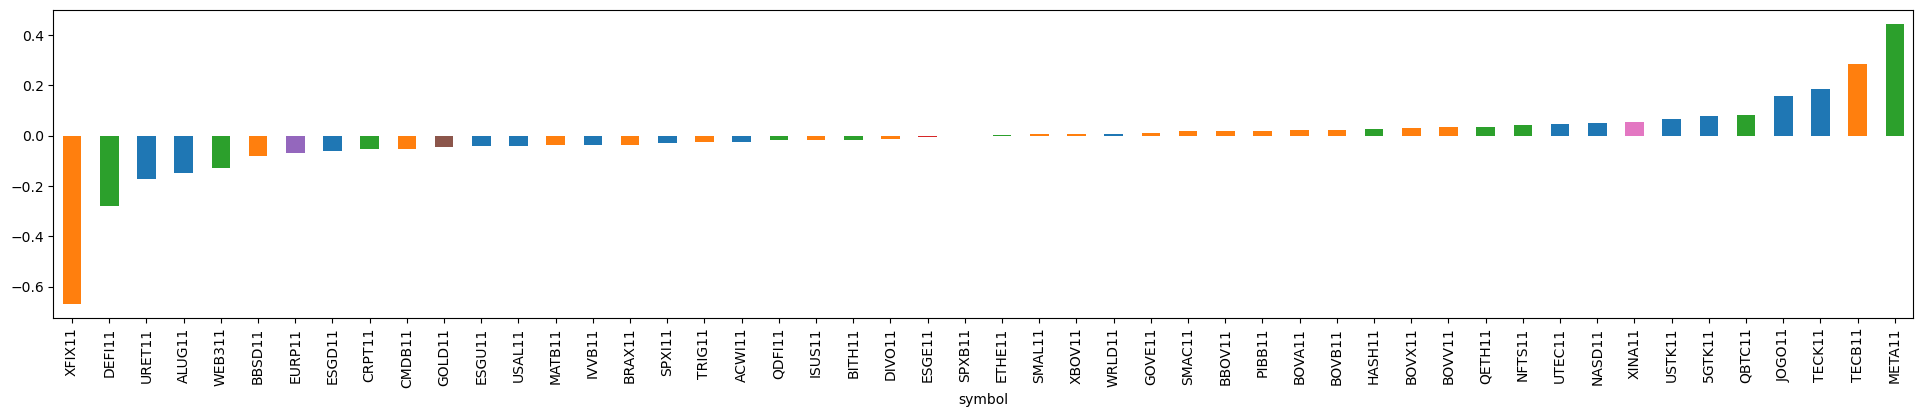

In [22]:
x = pca.loadings.loc[:, "comp_04"].sort_values()
x.plot.bar(figsize=(24, 4), color=geoc.loc[x.index])

In [23]:
data = rets.loc[:, geo[geo == "BR"].index]
xx = data.corr()
idx = xx.loc["BOVA11",:].sort_values().index
xx.loc[idx, idx].style.background_gradient(cmap='coolwarm')

symbol,XFIX11,TECB11,MATB11,CMDB11,TRIG11,SMAL11,SMAC11,BBSD11,ISUS11,BRAX11,DIVO11,XBOV11,BBOV11,GOVE11,PIBB11,BOVX11,BOVV11,BOVB11,BOVA11
symbol,,,,,,,,,,,,,,,,,,,
XFIX11,1.000000,0.010175,0.094100,0.116749,0.158456,0.125346,0.122319,0.180017,0.142850,0.165709,0.116421,0.126533,0.113809,0.143484,0.125783,0.115644,0.119244,0.127392,0.117388
TECB11,0.010175,1.000000,0.120387,0.088356,0.223497,0.182179,0.221888,0.139312,0.198726,0.200087,0.152938,0.188811,0.203731,0.196195,0.191526,0.194865,0.193287,0.201316,0.185559
MATB11,0.094100,0.120387,1.000000,0.708722,0.292320,0.406346,0.397288,0.553124,0.384697,0.573239,0.628948,0.555351,0.552018,0.552857,0.611402,0.592251,0.596778,0.591938,0.576599
CMDB11,0.116749,0.088356,0.708722,1.000000,0.424055,0.507671,0.487574,0.618285,0.487936,0.694625,0.667867,0.650852,0.656066,0.650293,0.698459,0.680036,0.688668,0.685715,0.677043
TRIG11,0.158456,0.223497,0.292320,0.424055,1.000000,0.851953,0.897922,0.779133,0.850224,0.755733,0.699614,0.715254,0.741747,0.780548,0.713632,0.744632,0.741627,0.752186,0.716597
SMAL11,0.125346,0.182179,0.406346,0.507671,0.851953,1.000000,0.957484,0.825069,0.911167,0.807712,0.809116,0.820720,0.824858,0.854605,0.830968,0.853110,0.849125,0.856504,0.838887
SMAC11,0.122319,0.221888,0.397288,0.487574,0.897922,0.957484,1.000000,0.827369,0.930090,0.815042,0.812265,0.828208,0.842574,0.871814,0.831671,0.859633,0.852160,0.864866,0.839849
BBSD11,0.180017,0.139312,0.553124,0.618285,0.779133,0.825069,0.827369,1.000000,0.841944,0.868895,0.879347,0.822247,0.848359,0.861447,0.837639,0.859588,0.850886,0.861971,0.840258
ISUS11,0.142850,0.198726,0.384697,0.487936,0.850224,0.911167,0.930090,0.841944,1.000000,0.835842,0.843122,0.859327,0.867216,0.894327,0.854123,0.886805,0.883076,0.895231,0.873343


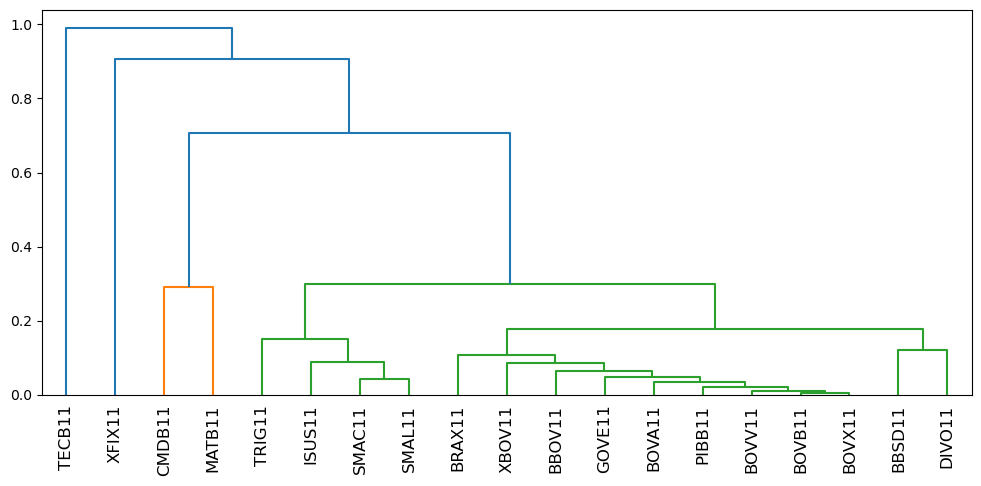

In [24]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

plt.figure(figsize=(12,5))
dissimilarity = 1 - abs(xx)
Z = linkage(squareform(dissimilarity), method='complete')
dendrogram(Z, labels=data.columns, orientation='top', leaf_rotation=90);

- TECB11
- XFIX11
- MATB11
- TRIG11
- SMAL11
- BRAX11
- DIVO11

In [25]:
data = rets.loc[:, geo[geo == "US"].index]
xx = data.corr()
idx = xx.loc["SPXI11",:].sort_values().index
xx.loc[idx, idx].style.background_gradient(cmap='coolwarm')

symbol,SPXB11,JOGO11,ALUG11,URET11,TECK11,ESGD11,5GTK11,USTK11,WRLD11,ACWI11,UTEC11,NASD11,IVVB11,ESGU11,USAL11,SPXI11
symbol,,,,,,,,,,,,,,,,
SPXB11,1.000000,0.536209,0.535667,0.473128,0.465823,0.608015,0.593900,0.620207,0.637569,0.677820,0.641243,0.671855,0.656214,0.667222,0.679751,0.592912
JOGO11,0.536209,1.000000,0.550971,0.493248,0.707884,0.695956,0.728987,0.704729,0.661673,0.689811,0.693720,0.695179,0.644173,0.677940,0.674533,0.678905
ALUG11,0.535667,0.550971,1.000000,0.929685,0.538100,0.686226,0.697153,0.637330,0.695440,0.733525,0.671077,0.667128,0.733150,0.758914,0.765281,0.755181
URET11,0.473128,0.493248,0.929685,1.000000,0.532647,0.680074,0.684418,0.619512,0.670931,0.732412,0.677986,0.675586,0.739702,0.778658,0.773668,0.763719
TECK11,0.465823,0.707884,0.538100,0.532647,1.000000,0.642530,0.734966,0.810481,0.686075,0.728553,0.832763,0.853848,0.738847,0.767086,0.768830,0.780406
ESGD11,0.608015,0.695956,0.686226,0.680074,0.642530,1.000000,0.748421,0.737812,0.796425,0.888975,0.785901,0.777766,0.817945,0.848519,0.846261,0.830794
5GTK11,0.593900,0.728987,0.697153,0.684418,0.734966,0.748421,1.000000,0.836095,0.794644,0.796742,0.876275,0.861182,0.823730,0.860413,0.857771,0.840996
USTK11,0.620207,0.704729,0.637330,0.619512,0.810481,0.737812,0.836095,1.000000,0.765528,0.815833,0.936785,0.906482,0.832100,0.873870,0.872037,0.852157
WRLD11,0.637569,0.661673,0.695440,0.670931,0.686075,0.796425,0.794644,0.765528,1.000000,0.833663,0.844732,0.838295,0.834488,0.868672,0.871830,0.858221


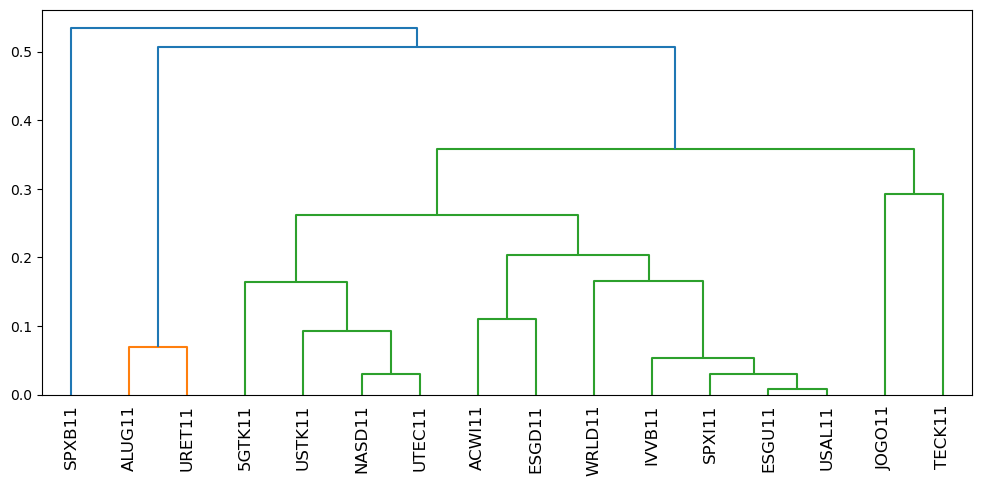

In [26]:
plt.figure(figsize=(12,5))
dissimilarity = 1 - abs(xx)
Z = linkage(squareform(dissimilarity), 'complete')
dendrogram(Z, labels=data.columns, orientation='top', leaf_rotation=90);

In [27]:
data = rets.loc[:, geo[geo == "CRIPTO"].index]
xx = data.corr()
idx = xx.loc["HASH11",:].sort_values().index
xx.loc[idx, idx].style.background_gradient(cmap='coolwarm')

symbol,META11,WEB311,QDFI11,DEFI11,NFTS11,CRPT11,QETH11,QBTC11,BITH11,ETHE11,HASH11
symbol,,,,,,,,,,,
META11,1.000000,0.217668,0.260487,0.130444,0.190878,0.212863,0.335027,0.332383,0.266425,0.231838,0.317073
WEB311,0.217668,1.000000,0.437865,0.483936,0.205856,0.343304,0.460570,0.395740,0.379515,0.441371,0.412356
QDFI11,0.260487,0.437865,1.000000,0.422340,0.354499,0.466178,0.554124,0.491743,0.463573,0.512674,0.469832
DEFI11,0.130444,0.483936,0.422340,1.000000,0.329500,0.376449,0.497715,0.468953,0.443897,0.527551,0.496587
NFTS11,0.190878,0.205856,0.354499,0.329500,1.000000,0.414582,0.544220,0.521729,0.481325,0.528371,0.501715
CRPT11,0.212863,0.343304,0.466178,0.376449,0.414582,1.000000,0.608283,0.611046,0.701016,0.668340,0.694746
QETH11,0.335027,0.460570,0.554124,0.497715,0.544220,0.608283,1.000000,0.742029,0.686620,0.818803,0.804348
QBTC11,0.332383,0.395740,0.491743,0.468953,0.521729,0.611046,0.742029,1.000000,0.823041,0.687233,0.821730
BITH11,0.266425,0.379515,0.463573,0.443897,0.481325,0.701016,0.686620,0.823041,1.000000,0.727980,0.842301


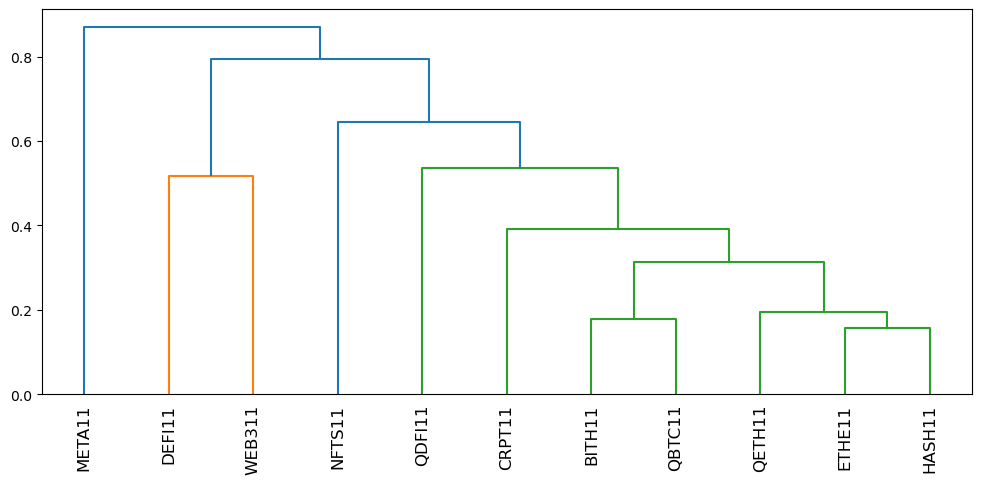

In [28]:
plt.figure(figsize=(12,5))
dissimilarity = 1 - abs(xx)
Z = linkage(squareform(dissimilarity), 'complete')
dendrogram(Z, labels=data.columns, orientation='top', leaf_rotation=90);

<Axes: xlabel='refdate'>

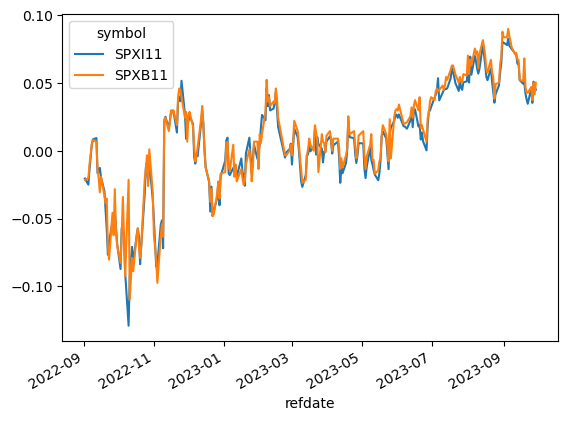

In [29]:
data = rets.loc[:, ["SPXI11", "SPXB11"]]
data.cumsum().plot()

In [30]:
X = sm.add_constant(data["SPXI11"])
y = data["SPXB11"]
results = sm.OLS(y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SPXB11   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     144.2
Date:                Sun, 22 Oct 2023   Prob (F-statistic):           7.82e-27
Time:                        21:17:38   Log-Likelihood:                 787.80
No. Observations:                 268   AIC:                            -1572.
Df Residuals:                     266   BIC:                            -1564.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.885e-05      0.001      0.088      0.930      -0.001       0.002
SPXI11         0.7062      0.059     12.009      0.000       0.590       0.822
==============================================================================
Omnibus:                      131.946   Durbin-Watson:                   3.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13622.999
Skew:                          -0.916   Prob(JB):                         0.00
Kurtosis:                      37.880   Cond. No.                         74.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: xlabel='refdate'>

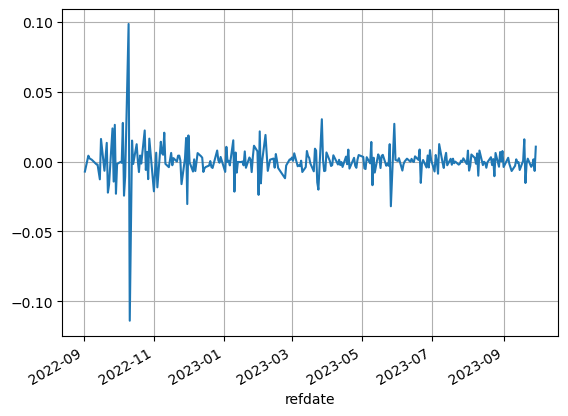

In [31]:
results.resid.plot(grid=True)

In [32]:
rlm_results = sm.RLM(y, X, M=sm.robust.norms.HuberT()).fit()
rlm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                 SPXB11   No. Observations:                  268
Model:                            RLM   Df Residuals:                      266
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 22 Oct 2023                                         
Time:                        21:17:38                                         
No. Iterations:                    21                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.374      0.708      -0.001       0.001
SPXI11         0.8700      0.029     29.622      0.000       0.812       0.928
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

<Axes: xlabel='refdate'>

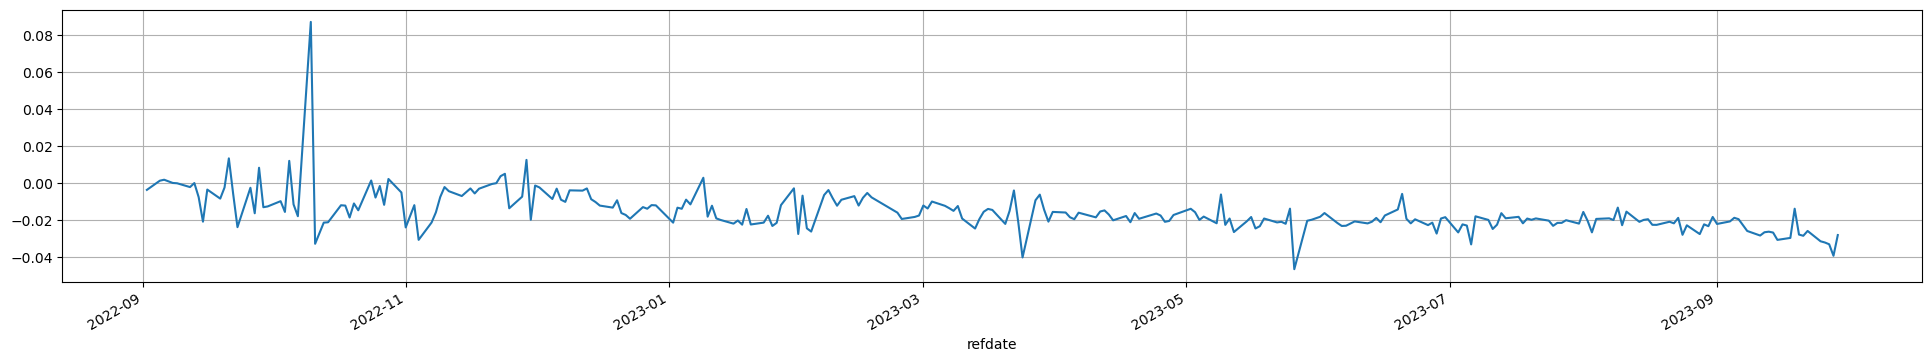

In [33]:
rlm_results.resid.cumsum().plot(grid=True, figsize=(24, 4))

<Axes: xlabel='refdate'>

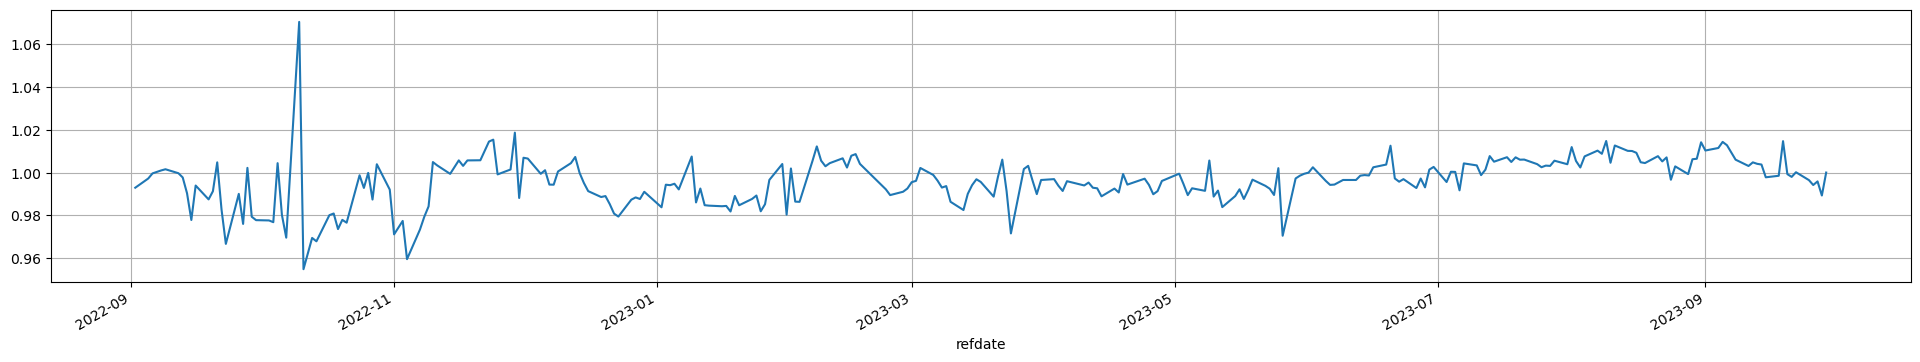

In [37]:
np.exp(results.resid.cumsum()).plot(grid=True, figsize=(24, 4))

In [150]:
rlm_results.resid.std() * np.sqrt(252)

0.2064853743337287

In [151]:
prices.loc[:, ["SPXI11", "SPXB11"]]

symbol,SPXI11,SPXB11
refdate,,
2022-09-01,222.00,8.94
2022-09-02,217.50,8.75
2022-09-05,216.51,8.76
2022-09-06,218.90,8.85
2022-09-08,223.01,8.98
...,...,...
2023-09-25,232.40,9.37
2023-09-26,229.97,9.28
2023-09-27,233.61,9.40


In [152]:
n = 232.20 / 9.4

In [153]:
# n quantidade de ações
- 232.20 * 100 + 9.4 * 100 * n

-3.637978807091713e-12

In [158]:
data.std() * np.sqrt(252)

symbol
SPXI11    0.212223
SPXB11    0.252756
dtype: float64

<Axes: xlabel='refdate'>

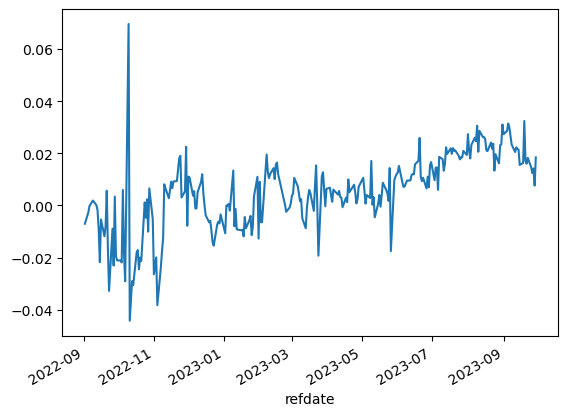

In [160]:
strat = data["SPXB11"] - data["SPXI11"] * results.params[1]
strat.cumsum().plot()

<Axes: xlabel='refdate'>

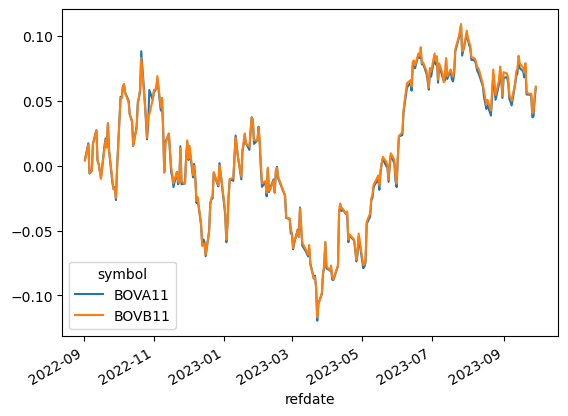

In [141]:
data = rets.loc[:, ["BOVA11", "BOVB11"]]
data.cumsum().plot()

In [142]:
X = sm.add_constant(data["BOVA11"])
y = data["BOVB11"]
results = sm.OLS(y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BOVB11   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     6834.
Date:                Sun, 15 Oct 2023   Prob (F-statistic):          9.78e-192
Time:                        21:27:41   Log-Likelihood:                 1227.2
No. Observations:                 268   AIC:                            -2450.
Df Residuals:                     266   BIC:                            -2443.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.87e-05      0.000      0.123      0.902      -0.000       0.000
BOVA11         0.9389      0.011     82.667      0.000       0.917       0.961
==============================================================================
Omnibus:                      178.185   Durbin-Watson:                   2.929
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18319.641
Skew:                          -1.706   Prob(JB):                         0.00
Kurtosis:                      43.360   Cond. No.                         74.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: xlabel='refdate'>

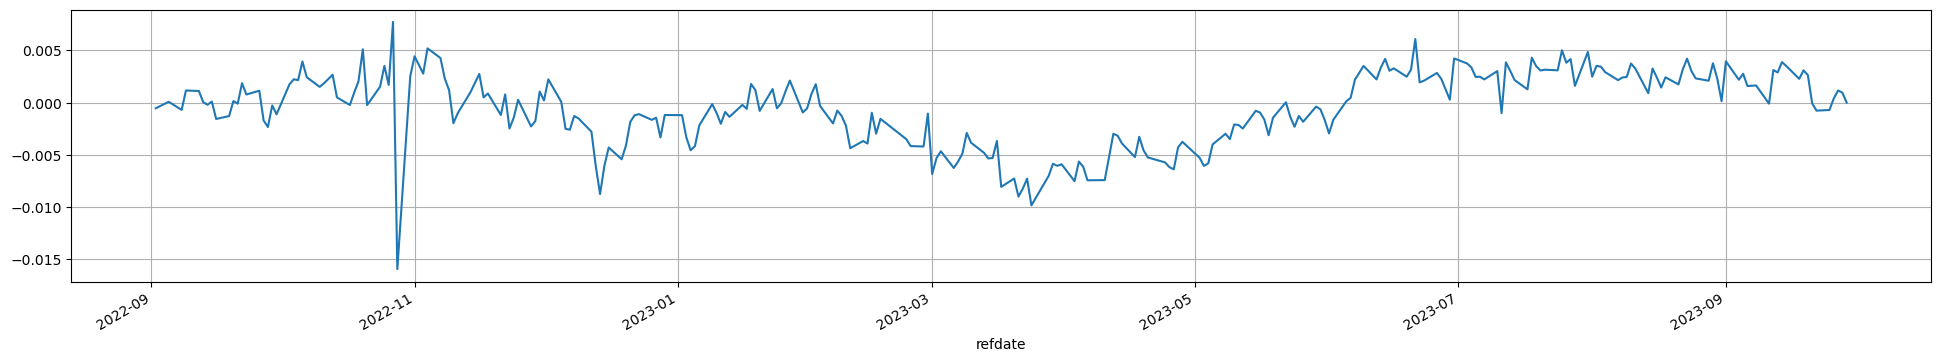

In [143]:
results.resid.cumsum().plot(grid=True, figsize=(24, 4))

<Axes: xlabel='refdate'>

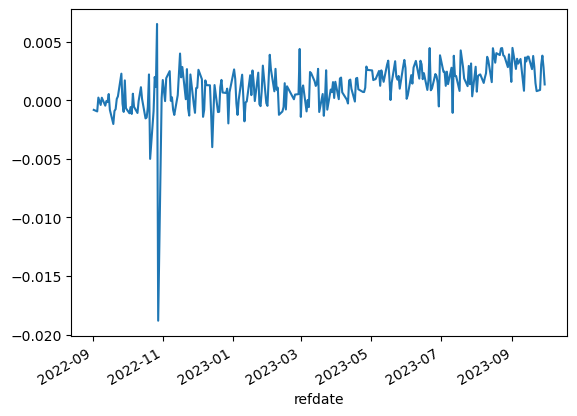

In [144]:
strat = data["BOVB11"] - data["BOVA11"]
strat.cumsum().plot()